Try:

```
[ ] Way more bits.
[ ] Soft version.
[x] No narrow in gumble sampling.
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data

In [5]:
CUDA = torch.cuda.is_available()

In [6]:
#transform
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x>0.5,
        lambda x: x.float(),
    ])

In [7]:
# dataset loading
bsize = 100
train_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=True, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=False, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)

In [8]:
# hyperparameters
N = 4
k = 2
tau = 1.
SEED = 1337

In [9]:
torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)

In [10]:
# TODO: UPDATE TO BINARY GUMBEL (REFER TO L0-REG PAPER)
# gumbel-softmax
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    v = Variable(torch.log(-torch.log(U + eps) + eps))
    if CUDA:
        v = v.cuda()
    return -v

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [11]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 2*N),
            nn.ReLU(),
        )
        
    def forward(self, x):
        bits = self.net(x)
        bits = bits.view(-1, N, 2)
        return bits

In [12]:
def prob(outputs, N=N, k=k):
    outputs = [F.softmax(out, dim=-1) for out in outputs]
    return torch.cat(outputs, dim=1).view(-1, N, k)

def sample(l):
    gs = gumbel_softmax(l, tau)
    #return gs.narrow(1,0,1)
    return gs

In [13]:
class Decoder(nn.Module):
    '''
    Input to the decoder can be any number of bits up to N bits.
    Eg. if bit pattern is 101 but N is 5, the input looks like:
    10 01 10 00 00
    '''
    def __init__(self):
        super(Decoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2*N, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.net(x)

In [14]:
E = Encoder()
D = Decoder()

In [15]:
if CUDA:
    E.cuda()
    D.cuda()

In [16]:
from itertools import product
    
log_two_pow_ns = []

for n in range(N+1):
    log_two_pow_n = Variable(torch.Tensor([2**n]).log(), requires_grad=False)
    if CUDA:
        log_two_pow_n = log_two_pow_n.cuda()
    log_two_pow_ns.append(log_two_pow_n)

def get_dependent_prior_loss(x):
    acc = Variable(torch.zeros(2**N))
    if CUDA:
        acc = acc.cuda()
    acc_i = 0
    
    batch_size = x.shape[0]
    
    def get_kl(q, path, n, batch_size):
        _idx = path.data
        select_mat = Variable(torch.stack([1-_idx, _idx]).t(), requires_grad=False)
        if CUDA:
            select_mat = select_mat.cuda()
        select_mat = select_mat.expand(torch.Size([batch_size]) + select_mat.shape)
        probs = q.mul(select_mat).sum(-1) # shape (batch x N)
        log_q = (probs+1e-20).log().sum(-1) # shape (batch)
        kl_term = log_q.exp().mul(log_two_pow_ns[n] + log_q) # shape (batch)
        kl_term = kl_term.mean() # shape (1) - take sum over minibatch
        return kl_term
    
    for _path in product(range(2), repeat=N):
        path = Variable(torch.Tensor(_path), requires_grad=False)
        if CUDA:
            path = path.cuda()
        
        outputs = E(x)
        outputs = outputs.permute(1,0,2) # make it like the list we had before

        kl_term = 0
        
        for nn in range(1, N+1):
            q = prob(outputs[:nn], nn)
            kl_term += get_kl(q, path[:nn], nn, batch_size)

        acc[acc_i] = kl_term
        acc_i += 1

    return acc.sum()

In [17]:
# TESTING
# Hacky! Getting a data point.
for batch_idx, (data, _) in enumerate(train_loader):
    data = Variable(data)
    if CUDA:
        data = data.cuda()
    x = data.view(-1,784)
    x = x[0:4]
    break
    
get_dependent_prior_loss(x)

Variable containing:
1.00000e-03 *
  4.5871
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [18]:
def loss_function(recons, x):
    _bsize = x.shape[0]
    BCES = [F.binary_cross_entropy(recon_x, x, size_average=False)/_bsize for recon_x in recons]
    BCE = sum(BCES)
    
    # Assuming dependent latent
    KLD = get_dependent_prior_loss(x) # this sums together the KLD
    
    return BCE, KLD

In [19]:
params = [
    {'params':E.parameters()},
    {'params':D.parameters()}
]
optimizer = optim.Adam(params, lr=1e-4)

In [20]:
best_loss_sofar = 9999

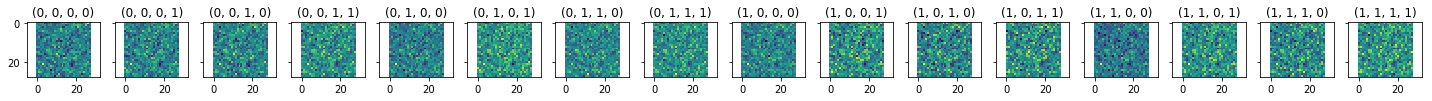

In [21]:
from itertools import product

def debug():
    f, axes = plt.subplots(1, 2**N, sharey=True, figsize=(25,1))
    kk = 0

    def make_variable(path):
        value = []
        for bit in path:
            if bit == 0:
                value.append(0)
                value.append(1)
            else:
                value.append(1)
                value.append(0)
        t = torch.Tensor([value]).type(torch.FloatTensor)
        v = Variable(t)
        if CUDA:
            v = v.cuda()
        return v

    for path in product(range(2), repeat=N):
        v = make_variable(path)
        #print(v)
        w = D(v)

        ax = axes[kk]
        ax.set_title(path)
        ax.imshow(w.view(28,28).cpu().data.numpy())
        kk += 1
    plt.show()
    
debug()

In [22]:
ZEROS = []
for nn in range(0,2*N,2):
    _v = Variable(torch.zeros(1,nn))
    if CUDA:
        _v = _v.cuda()
    ZEROS.append(_v)

In [ ]:
def pad_decoder_input(inp):
    bits_to_pad = int((2*N - inp.shape[1])/2)
    if bits_to_pad > 0:
        pad = ZEROS[bits_to_pad]
        pad = pad.expand(inp.shape[0], pad.shape[1])
        inp = torch.cat([inp, pad], 1)
    return inp
    
def train(epoch):
    global best_loss_sofar
    train_bce_loss = 0
    train_kld_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if CUDA:
            data = data.cuda()
        x = data.view(-1,784)
        optimizer.zero_grad()
        
        outputs = E(x)
        recons = []
        samples = []
        for nn in range(N):
            s = sample(outputs[:,nn,:])
            samples.append(s)
            inp = pad_decoder_input(torch.cat(samples, 1))
            recons.append(D(inp))

        BCE, KLD = loss_function(recons, x)
        loss = BCE + KLD
        loss.backward()
        optimizer.step()  
        train_bce_loss += BCE.data[0]
        train_kld_loss += KLD.data[0]
        
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBCE loss: {:.6f}\tKLD loss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                BCE.data[0] / len(data),
                KLD.data[0] / len(data)))
            
    avg_bce_loss = train_bce_loss / len(train_loader.dataset)
    avg_kld_loss = train_kld_loss / len(train_loader.dataset)
    avg_loss = avg_bce_loss + avg_kld_loss
    print('====> Epoch: {} Average BCE loss: {:.4f}, Average KLD loss: {:.4f}, Total: {:.4f}'.format(
          epoch+1, avg_bce_loss, avg_kld_loss, avg_loss))
    
    if avg_loss < best_loss_sofar:
        print("Loss {} is better than previous best {}, saving model".format(avg_loss, best_loss_sofar))
#         save_model()
        best_loss_sofar = avg_loss
        debug()

In [ ]:
%%time
train(0)

Train Epoch: 1 [0/60000 (0%)]	BCE loss: 21.725989	KLD loss: 0.000028
Train Epoch: 1 [20000/60000 (33%)]	BCE loss: 8.872529	KLD loss: 0.179776
Train Epoch: 1 [40000/60000 (67%)]	BCE loss: 7.974218	KLD loss: 0.179087
====> Epoch: 1 Average BCE loss: 9.6904, Average KLD loss: 0.1602, Total: 9.8506
Loss 9.850626955435782 is better than previous best 9999, saving model


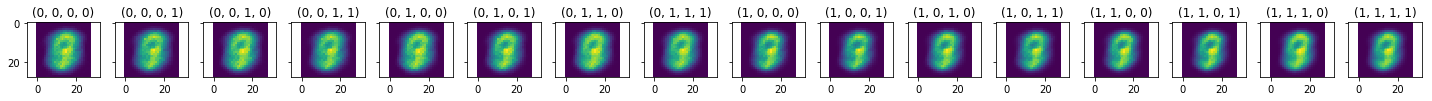

CPU times: user 30.1 s, sys: 820 ms, total: 30.9 s
Wall time: 30.3 s
Train Epoch: 2 [0/60000 (0%)]	BCE loss: 8.544741	KLD loss: 0.173238
Train Epoch: 2 [20000/60000 (33%)]	BCE loss: 8.280419	KLD loss: 0.173222
Train Epoch: 2 [40000/60000 (67%)]	BCE loss: 8.493059	KLD loss: 0.173211
====> Epoch: 2 Average BCE loss: 8.2562, Average KLD loss: 0.1732, Total: 8.4294
Loss 8.429360413169862 is better than previous best 9.850626955435782, saving model


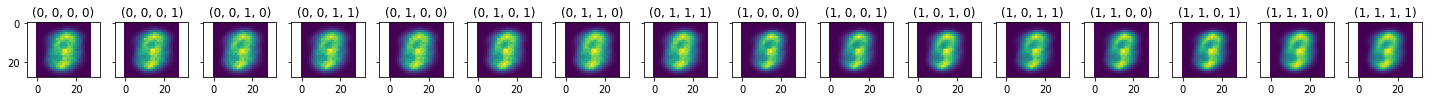

CPU times: user 29.4 s, sys: 856 ms, total: 30.2 s
Wall time: 29.5 s
Train Epoch: 3 [0/60000 (0%)]	BCE loss: 8.027515	KLD loss: 0.173238
Train Epoch: 3 [20000/60000 (33%)]	BCE loss: 8.455160	KLD loss: 0.172864
Train Epoch: 3 [40000/60000 (67%)]	BCE loss: 8.098641	KLD loss: 0.059321
====> Epoch: 3 Average BCE loss: 8.1958, Average KLD loss: 0.1280, Total: 8.3238
Loss 8.32378552646637 is better than previous best 8.429360413169862, saving model


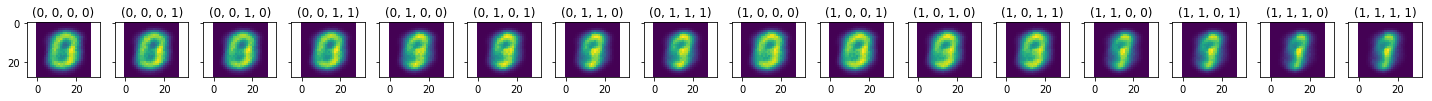

CPU times: user 29.7 s, sys: 956 ms, total: 30.7 s
Wall time: 29.9 s
Train Epoch: 4 [0/60000 (0%)]	BCE loss: 8.163962	KLD loss: 0.061308
Train Epoch: 4 [20000/60000 (33%)]	BCE loss: 7.954860	KLD loss: 0.043306
Train Epoch: 4 [40000/60000 (67%)]	BCE loss: 8.469623	KLD loss: 0.048922
====> Epoch: 4 Average BCE loss: 7.9394, Average KLD loss: 0.0549, Total: 7.9943
Loss 7.99428055494229 is better than previous best 8.32378552646637, saving model


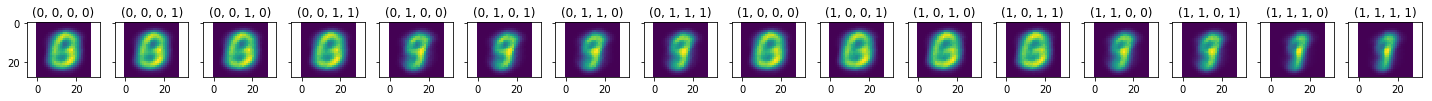

CPU times: user 30.5 s, sys: 960 ms, total: 31.5 s
Wall time: 30.8 s
Train Epoch: 5 [0/60000 (0%)]	BCE loss: 7.702036	KLD loss: 0.047059
Train Epoch: 5 [20000/60000 (33%)]	BCE loss: 7.503986	KLD loss: 0.063126
Train Epoch: 5 [40000/60000 (67%)]	BCE loss: 7.929478	KLD loss: 0.053218
====> Epoch: 5 Average BCE loss: 7.9052, Average KLD loss: 0.0533, Total: 7.9585
Loss 7.9584979804635045 is better than previous best 7.99428055494229, saving model


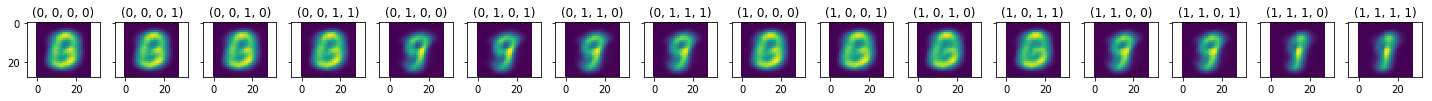

CPU times: user 29.8 s, sys: 840 ms, total: 30.6 s
Wall time: 29.8 s
Train Epoch: 6 [0/60000 (0%)]	BCE loss: 7.743414	KLD loss: 0.055976
Train Epoch: 6 [20000/60000 (33%)]	BCE loss: 8.014031	KLD loss: 0.055764
Train Epoch: 6 [40000/60000 (67%)]	BCE loss: 7.725833	KLD loss: 0.059845
====> Epoch: 6 Average BCE loss: 7.8836, Average KLD loss: 0.0554, Total: 7.9390
Loss 7.939006201203664 is better than previous best 7.9584979804635045, saving model


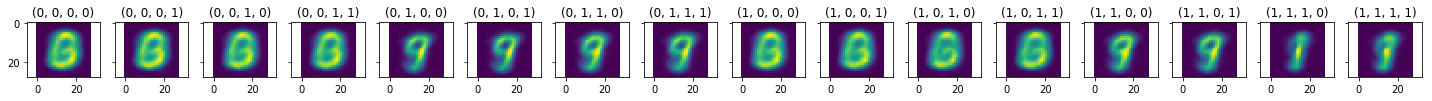

CPU times: user 29.9 s, sys: 992 ms, total: 30.8 s
Wall time: 30.1 s
Train Epoch: 7 [0/60000 (0%)]	BCE loss: 7.791932	KLD loss: 0.059610
Train Epoch: 7 [20000/60000 (33%)]	BCE loss: 7.772529	KLD loss: 0.063669
Train Epoch: 7 [40000/60000 (67%)]	BCE loss: 7.689574	KLD loss: 0.067884
====> Epoch: 7 Average BCE loss: 7.8455, Average KLD loss: 0.0667, Total: 7.9122
Loss 7.912169721706708 is better than previous best 7.939006201203664, saving model


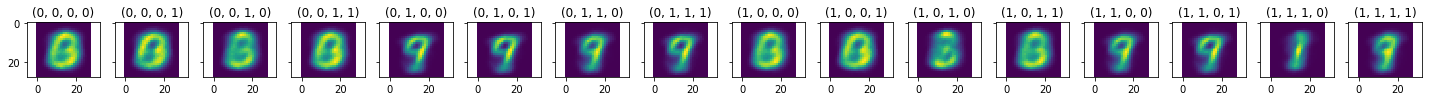

CPU times: user 29.7 s, sys: 956 ms, total: 30.6 s
Wall time: 29.8 s
Train Epoch: 8 [0/60000 (0%)]	BCE loss: 7.594241	KLD loss: 0.080446
Train Epoch: 8 [20000/60000 (33%)]	BCE loss: 7.607614	KLD loss: 0.087178
Train Epoch: 8 [40000/60000 (67%)]	BCE loss: 7.661810	KLD loss: 0.090641
====> Epoch: 8 Average BCE loss: 7.8098, Average KLD loss: 0.0747, Total: 7.8845
Loss 7.884512914784749 is better than previous best 7.912169721706708, saving model


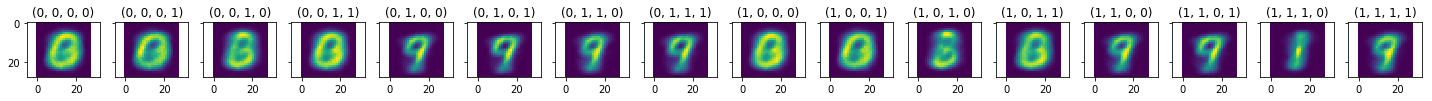

CPU times: user 29.8 s, sys: 840 ms, total: 30.6 s
Wall time: 29.9 s
Train Epoch: 9 [0/60000 (0%)]	BCE loss: 7.885421	KLD loss: 0.070698
Train Epoch: 9 [20000/60000 (33%)]	BCE loss: 7.888581	KLD loss: 0.069945
Train Epoch: 9 [40000/60000 (67%)]	BCE loss: 7.917920	KLD loss: 0.072679
====> Epoch: 9 Average BCE loss: 7.7990, Average KLD loss: 0.0763, Total: 7.8753
Loss 7.875275094954173 is better than previous best 7.884512914784749, saving model


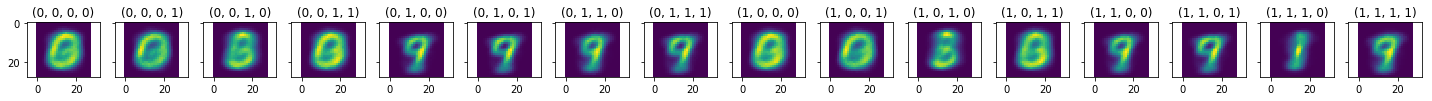

CPU times: user 30 s, sys: 924 ms, total: 30.9 s
Wall time: 30.1 s
Train Epoch: 10 [0/60000 (0%)]	BCE loss: 7.850107	KLD loss: 0.072099
Train Epoch: 10 [20000/60000 (33%)]	BCE loss: 7.872617	KLD loss: 0.078728
Train Epoch: 10 [40000/60000 (67%)]	BCE loss: 7.725478	KLD loss: 0.075805
====> Epoch: 10 Average BCE loss: 7.7991, Average KLD loss: 0.0751, Total: 7.8743
Loss 7.874277608545621 is better than previous best 7.875275094954173, saving model


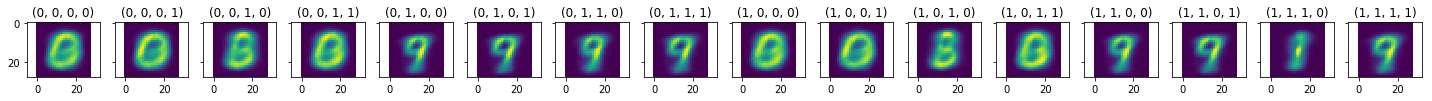

CPU times: user 29.8 s, sys: 900 ms, total: 30.7 s
Wall time: 29.9 s
Train Epoch: 11 [0/60000 (0%)]	BCE loss: 8.083210	KLD loss: 0.064018
Train Epoch: 11 [20000/60000 (33%)]	BCE loss: 7.373380	KLD loss: 0.080762
Train Epoch: 11 [40000/60000 (67%)]	BCE loss: 7.601191	KLD loss: 0.074597
====> Epoch: 11 Average BCE loss: 7.7993, Average KLD loss: 0.0745, Total: 7.8738
Loss 7.873796883265178 is better than previous best 7.874277608545621, saving model


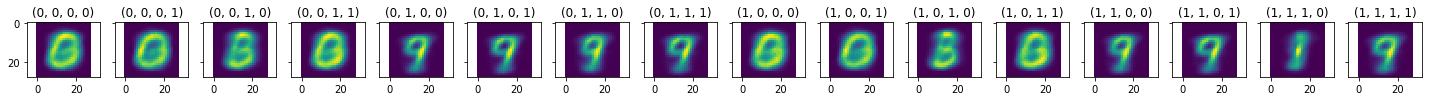

CPU times: user 30 s, sys: 912 ms, total: 30.9 s
Wall time: 29.7 s
Train Epoch: 12 [0/60000 (0%)]	BCE loss: 7.607677	KLD loss: 0.076188
Train Epoch: 12 [20000/60000 (33%)]	BCE loss: 7.639267	KLD loss: 0.071514
Train Epoch: 12 [40000/60000 (67%)]	BCE loss: 7.931792	KLD loss: 0.074387
====> Epoch: 12 Average BCE loss: 7.7979, Average KLD loss: 0.0749, Total: 7.8727
Loss 7.872734460632007 is better than previous best 7.873796883265178, saving model


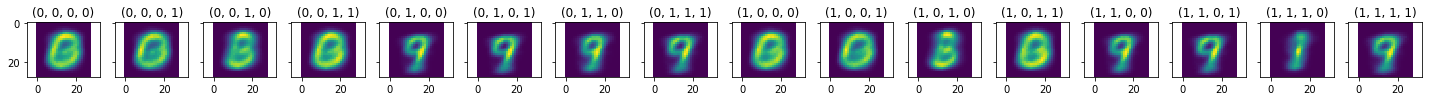

CPU times: user 30.1 s, sys: 788 ms, total: 30.9 s
Wall time: 30.1 s
Train Epoch: 13 [0/60000 (0%)]	BCE loss: 7.753896	KLD loss: 0.073131
Train Epoch: 13 [20000/60000 (33%)]	BCE loss: 7.464103	KLD loss: 0.082761
Train Epoch: 13 [40000/60000 (67%)]	BCE loss: 7.540243	KLD loss: 0.079034
====> Epoch: 13 Average BCE loss: 7.8029, Average KLD loss: 0.0732, Total: 7.8761
CPU times: user 28.8 s, sys: 364 ms, total: 29.1 s
Wall time: 29 s
Train Epoch: 14 [0/60000 (0%)]	BCE loss: 7.824664	KLD loss: 0.065808
Train Epoch: 14 [20000/60000 (33%)]	BCE loss: 8.039388	KLD loss: 0.074181
Train Epoch: 14 [40000/60000 (67%)]	BCE loss: 7.711016	KLD loss: 0.074135
====> Epoch: 14 Average BCE loss: 7.7985, Average KLD loss: 0.0742, Total: 7.8727
Loss 7.872654283618926 is better than previous best 7.872734460632007, saving model


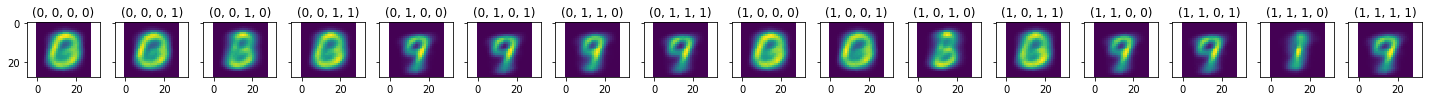

CPU times: user 30.3 s, sys: 788 ms, total: 31.1 s
Wall time: 30.6 s
Train Epoch: 15 [0/60000 (0%)]	BCE loss: 7.852743	KLD loss: 0.074280
Train Epoch: 15 [20000/60000 (33%)]	BCE loss: 7.937511	KLD loss: 0.071187
Train Epoch: 15 [40000/60000 (67%)]	BCE loss: 7.629207	KLD loss: 0.076498
====> Epoch: 15 Average BCE loss: 7.7993, Average KLD loss: 0.0741, Total: 7.8733
CPU times: user 29.6 s, sys: 372 ms, total: 30 s
Wall time: 29.9 s
Train Epoch: 16 [0/60000 (0%)]	BCE loss: 7.870317	KLD loss: 0.069674
Train Epoch: 16 [20000/60000 (33%)]	BCE loss: 7.766000	KLD loss: 0.073207
Train Epoch: 16 [40000/60000 (67%)]	BCE loss: 7.539880	KLD loss: 0.084022
====> Epoch: 16 Average BCE loss: 7.7973, Average KLD loss: 0.0754, Total: 7.8726
Loss 7.872633643698692 is better than previous best 7.872654283618926, saving model


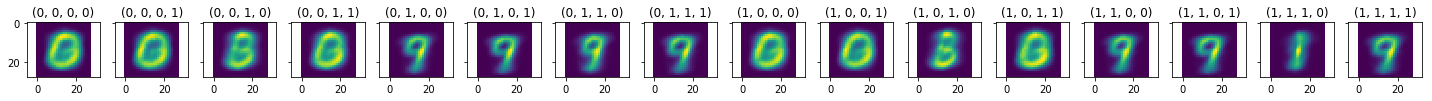

CPU times: user 30.4 s, sys: 876 ms, total: 31.3 s
Wall time: 30.7 s
Train Epoch: 17 [0/60000 (0%)]	BCE loss: 7.609165	KLD loss: 0.076814
Train Epoch: 17 [20000/60000 (33%)]	BCE loss: 7.706239	KLD loss: 0.079112
Train Epoch: 17 [40000/60000 (67%)]	BCE loss: 7.619658	KLD loss: 0.077727
====> Epoch: 17 Average BCE loss: 7.7964, Average KLD loss: 0.0745, Total: 7.8709
Loss 7.8709130061626436 is better than previous best 7.872633643698692, saving model


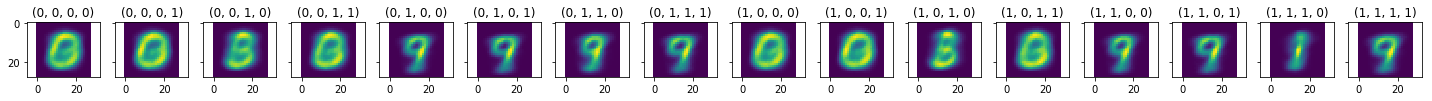

CPU times: user 30 s, sys: 816 ms, total: 30.8 s
Wall time: 30.1 s
Train Epoch: 18 [0/60000 (0%)]	BCE loss: 7.925492	KLD loss: 0.074434
Train Epoch: 18 [20000/60000 (33%)]	BCE loss: 7.799993	KLD loss: 0.076781
Train Epoch: 18 [40000/60000 (67%)]	BCE loss: 7.703682	KLD loss: 0.076300
====> Epoch: 18 Average BCE loss: 7.8018, Average KLD loss: 0.0732, Total: 7.8751
CPU times: user 29.8 s, sys: 520 ms, total: 30.3 s
Wall time: 30.3 s
Train Epoch: 19 [0/60000 (0%)]	BCE loss: 7.795482	KLD loss: 0.069898
Train Epoch: 19 [20000/60000 (33%)]	BCE loss: 7.774764	KLD loss: 0.068997
Train Epoch: 19 [40000/60000 (67%)]	BCE loss: 7.712623	KLD loss: 0.077030
====> Epoch: 19 Average BCE loss: 7.7997, Average KLD loss: 0.0744, Total: 7.8742
CPU times: user 29.5 s, sys: 420 ms, total: 29.9 s
Wall time: 29.9 s
Train Epoch: 20 [0/60000 (0%)]	BCE loss: 8.044368	KLD loss: 0.077127
Train Epoch: 20 [20000/60000 (33%)]	BCE loss: 7.761716	KLD loss: 0.069092
Train Epoch: 20 [40000/60000 (67%)]	BCE loss: 7.549485

KeyboardInterrupt: 

Train Epoch: 25 [0/60000 (0%)]	BCE loss: 7.687151	KLD loss: 0.071901


KeyboardInterrupt: 

Train Epoch: 26 [0/60000 (0%)]	BCE loss: 7.827328	KLD loss: 0.074618


KeyboardInterrupt: 

Train Epoch: 27 [0/60000 (0%)]	BCE loss: 7.891302	KLD loss: 0.080732


KeyboardInterrupt: 

Train Epoch: 28 [0/60000 (0%)]	BCE loss: 7.988057	KLD loss: 0.067227


KeyboardInterrupt: 

Train Epoch: 29 [0/60000 (0%)]	BCE loss: 7.982174	KLD loss: 0.071375


KeyboardInterrupt: 

Train Epoch: 30 [0/60000 (0%)]	BCE loss: 8.138843	KLD loss: 0.065403


KeyboardInterrupt: 

Train Epoch: 31 [0/60000 (0%)]	BCE loss: 7.612358	KLD loss: 0.068234


KeyboardInterrupt: 

Train Epoch: 32 [0/60000 (0%)]	BCE loss: 7.845436	KLD loss: 0.072789


KeyboardInterrupt: 

Train Epoch: 33 [0/60000 (0%)]	BCE loss: 7.840643	KLD loss: 0.068671


KeyboardInterrupt: 

Train Epoch: 34 [0/60000 (0%)]	BCE loss: 7.690359	KLD loss: 0.064461


KeyboardInterrupt: 

Train Epoch: 35 [0/60000 (0%)]	BCE loss: 8.097162	KLD loss: 0.066775


KeyboardInterrupt: 

Train Epoch: 36 [0/60000 (0%)]	BCE loss: 7.639811	KLD loss: 0.073799


KeyboardInterrupt: 

Train Epoch: 37 [0/60000 (0%)]	BCE loss: 7.894086	KLD loss: 0.066723


KeyboardInterrupt: 

Train Epoch: 38 [0/60000 (0%)]	BCE loss: 7.665676	KLD loss: 0.086824


KeyboardInterrupt: 

Train Epoch: 39 [0/60000 (0%)]	BCE loss: 7.656598	KLD loss: 0.075679


KeyboardInterrupt: 

Train Epoch: 40 [0/60000 (0%)]	BCE loss: 7.729637	KLD loss: 0.077164


KeyboardInterrupt: 

Train Epoch: 41 [0/60000 (0%)]	BCE loss: 7.970433	KLD loss: 0.073369


KeyboardInterrupt: 

Train Epoch: 42 [0/60000 (0%)]	BCE loss: 7.952086	KLD loss: 0.073330


KeyboardInterrupt: 

Train Epoch: 43 [0/60000 (0%)]	BCE loss: 7.734893	KLD loss: 0.078215


KeyboardInterrupt: 

Train Epoch: 44 [0/60000 (0%)]	BCE loss: 7.854403	KLD loss: 0.078467


KeyboardInterrupt: 

Train Epoch: 45 [0/60000 (0%)]	BCE loss: 7.634689	KLD loss: 0.081213


KeyboardInterrupt: 

Train Epoch: 46 [0/60000 (0%)]	BCE loss: 7.687289	KLD loss: 0.073414


KeyboardInterrupt: 

Train Epoch: 47 [0/60000 (0%)]	BCE loss: 7.767866	KLD loss: 0.070624


KeyboardInterrupt: 

Train Epoch: 48 [0/60000 (0%)]	BCE loss: 7.717520	KLD loss: 0.071563


KeyboardInterrupt: 

Train Epoch: 49 [0/60000 (0%)]	BCE loss: 7.892068	KLD loss: 0.078953


In [ ]:
for epoch in range(1,100):
    train(epoch)

In [ ]:
debug()